## TechLabs WS21, Learning Models
#### Stefanus Kohar

Work notes :
- Tensorflow regression tutorial : https://www.tensorflow.org/tutorials/keras/regression
- sample from Notion page : https://towardsdatascience.com/regression-based-neural-networks-with-tensorflow-v2-0-predicting-average-daily-rates-e20fffa7ac9a
- MinMax scaler used, after preliminary testing on RF, slightly better result with MinMax

Resources :
- Standardization - Normalization : https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/
- Gaussian processes, using tensorflow : https://peterroelants.github.io/posts/gaussian-process-tutorial/
    - Understanding usage of Kernel, for SciKit Gaussian
    - Kernel documentation (scikit) : https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes
- Evaluation Metrics : https://towardsdatascience.com/20-popular-machine-learning-metrics-part-1-classification-regression-evaluation-metrics-1ca3e282a2ce (member only, limited free read available)

to explore :
- Gaussian process model (https://scikit-learn.org/stable/modules/gaussian_process.html)
    - sample from kaggle : https://www.kaggle.com/carlmcbrideellis/gaussian-process-regression-sample-script
- Pytorch tabular : https://pytorch-tabular.readthedocs.io/en/latest/, to read though each section
    - withdrawn, compatibility issues.

problems :
- 02/03, xlrd reader engine problem (__solve__, reinstall pandas)

In [81]:
#Additional Module, to be added singularly for testing


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math

from numpy.random import seed
seed(1)

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from xgboost import plot_tree
from xgboost import XGBRegressor

import tensorflow as tf
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from scipy import stats

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [4]:
# pytorch_tabular packages, abandoned
from pytorch_tabular import TabularModel
from pytorch_tabular.models import CategoryEmbeddingModelConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig

In [ ]:
#Future development, automatically pulling sheet names
sheet = pd.ExcelFile("sample.xlsx")
sheet_count = len(sheet.sheet_names)

___Please extract file before continuing further___

In [5]:
file = "A-to-B.xlsx"
AB_TC = pd.read_excel(file, sheet_name="Sheet C")
AB_TB = pd.read_excel(file, sheet_name="Sheet B")
AB_TA = pd.read_excel(file, sheet_name="Sheet A")
AB_all = pd.read_excel("A-to-B_combined.xlsx")

file = "B-to-D.xlsx"
BD_TC = pd.read_excel(file, sheet_name="Sheet C")
BD_TB = pd.read_excel(file, sheet_name="Sheet B")
BD_TA = pd.read_excel(file, sheet_name="Sheet A")
BD_all = pd.read_excel("B-to-D_combined.xlsx")

file = "A-to-D.xlsx"
AD_TC = pd.read_excel(file, sheet_name="Sheet C")
AD_TB = pd.read_excel(file, sheet_name="Sheet B")
AD_TA = pd.read_excel(file, sheet_name="Sheet A")
AD_all = pd.read_excel("A-to-D_combined.xlsx")

### Prediction models

___Data Preparation___<br>
(Same scaling and transformation for all)

In [30]:
data = AD_all.iloc[:,[2,6,7,8,9,10]].copy()
cols = data.columns
results = pd.DataFrame(columns=['MAE', 'RMSE', 'SI', 'Pearson'])

X = data.iloc[:,[1,2,3,4,5]]
Y = data.iloc[:,0].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 3, shuffle = True)

Y_train = np.reshape(Y_train, (-1,1))
Y_test = np.reshape(Y_test, (-1,1))

X_scaler = MinMaxScaler().fit(X_train)
Y_scaler = MinMaxScaler().fit(Y_train)

X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
Y_train = Y_scaler.transform(Y_train)
Y_test_sc = Y_scaler.transform(Y_test)

#### Random Forest Regression

In [31]:
rf = RandomForestRegressor(max_depth=40,n_estimators=120, criterion='absolute_error', min_samples_split=5)
rf.fit(X_train, Y_train.ravel())

RandomForestRegressor(criterion='absolute_error', max_depth=40,
                      min_samples_split=5, n_estimators=120)

In [32]:
Y_rf = rf.predict(X_test)
Y_rf = np.reshape(Y_rf, (-1,1))
Y_rf = Y_scaler.inverse_transform(Y_rf)

In [33]:
mae = metrics.mean_absolute_error(Y_test, Y_rf)
rmse = metrics.mean_squared_error(Y_test, Y_rf, squared = False)

SI = (rmse/Y_rf.mean())*100

pear = stats.pearsonr(Y_test.ravel(), Y_rf)

met_rf = pd.DataFrame([[mae, rmse, SI, pear[0].item()]], columns=results.columns, index=['Random Forest'])

#### Tensorflow Regression

In [34]:
nn = Sequential()
nn.add(Dense(5, input_dim=5, kernel_initializer='normal', activation='relu'))
nn.add(Dense(128,activation='relu'))
nn.add(Dense(1))
nn.summary()

nn.compile(loss='mae', optimizer='adam', metrics=['mse','mae'])
nn_report=nn.fit(X_train, Y_train, epochs=50, verbose=0, validation_split=0.15)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 30        
_________________________________________________________________
dense_1 (Dense)              (None, 128)               768       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 927
Trainable params: 927
Non-trainable params: 0
_________________________________________________________________


In [35]:
Y_nn = nn.predict(X_test)
Y_nn = np.reshape(Y_nn, (-1,1))
Y_nn = Y_scaler.inverse_transform(Y_nn)

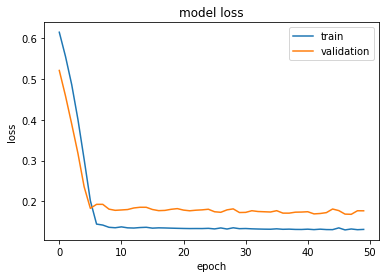

In [37]:
# Loss Report
plt.plot(nn_report.history['loss'])
plt.plot(nn_report.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [36]:
mae = metrics.mean_absolute_error(Y_test, Y_nn)
rmse = metrics.mean_squared_error(Y_test, Y_nn, squared = False)

SI = (rmse/Y_nn.mean())*100

pear = stats.pearsonr(Y_test.ravel(), Y_nn)

met_nn = pd.DataFrame([[mae, rmse, SI, pear[0].item()]], columns=results.columns, index=['Neural Network'])

In [74]:
# Reset session, for model changes
tf.keras.backend.clear_session()

#### Gaussian process regression

In [38]:
gpr_kernel = DotProduct() + WhiteKernel(noise_level=0.5)
gpr = GaussianProcessRegressor(kernel=gpr_kernel).fit(X_train, Y_train)

In [39]:
Y_gpr = gpr.predict(X_test)
Y_gpr = np.reshape(Y_gpr, (-1,1))
Y_gpr = Y_scaler.inverse_transform(Y_gpr)

In [40]:
mae = metrics.mean_absolute_error(Y_test, Y_gpr)
rmse = metrics.mean_squared_error(Y_test, Y_gpr, squared = False)

SI = (rmse/Y_gpr.mean())*100

pear = stats.pearsonr(Y_test.ravel(), Y_gpr)

met_gpr = pd.DataFrame([[mae, rmse, SI, pear[0].item()]], columns=results.columns, index=['Gaussian Process'])

#### Pytorch Tabular, abandoned

In [24]:
data_config = DataConfig(target=X.columns, continuous_cols=X.columns)
trainer_config = TrainerConfig(auto_lr_find=True, batch_size=30, max_epochs=100, gpus=None)
optimizer_config = OptimizerConfig()
model_config = CategoryEmbeddingModelConfig(task="regression", layers="5-128-1", activation="ReLU", learning_rate = 1e-3)

In [ ]:
tabular_model = TabularModel(data_config=data_config,model_config=model_config,
                             optimizer_config=optimizer_config,trainer_config=trainer_config)

#### Comparing Results

In [41]:
# Table of model metrics
results = pd.concat([met_rf, met_nn, met_gpr])
results

,MAE,RMSE,SI,Pearson
Random Forest,0.717960,0.932338,1.126044,0.721319
Neural Network,1.014883,1.392477,1.672255,0.167051
Gaussian Process,1.003868,1.315344,1.590694,0.376939


In [42]:
# Table for Value comparison
Y_values = pd.DataFrame(np.concatenate((Y_test, Y_rf, Y_nn, Y_gpr), axis=1))
Y_values.set_axis(['Test set','Random Forest', 'Neural Network', 'Gaussian Process'], axis=1, inplace=True)
Y_values

,Test set,Random Forest,Neural Network,Gaussian Process
0,81.860974,81.247381,83.054222,82.950446
1,84.077624,83.756269,83.738991,84.363894
2,84.166478,83.883265,83.901985,83.852130
3,83.600000,83.783296,83.018700,82.378750
4,83.136733,81.952674,83.421516,81.964370
5,83.464268,82.675278,83.945541,83.637604
6,83.600000,82.832604,83.102966,82.536091
7,83.487000,82.858764,83.069183,82.406824
8,83.900000,83.160139,82.948380,82.175652
9,80.700000,81.471191,82.935799,81.464761


In [ ]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(16,20))
plt.suptitle('Predicted data', fontsize='xx-large', y=0.9)
ax[0].plot(Y_rf, '--b',label = 'Random Forest')
ax[0].plot(Y_test, '-r',label = 'Test data')
ax[0].tick_params(axis='x', bottom=False, labelbottom=False)
ax[0].set_ylabel('T3028 Yield [%]')
ax[0].legend()
ax[1].plot(Y_nn, '--b',label = 'Neural Network')
ax[1].plot(Y_test, '-r',label = 'Test data')
ax[1].tick_params(axis='x', bottom=False, labelbottom=False)
ax[1].set_ylabel('T3028 Yield [%]')
ax[1].legend()
ax[2].plot(Y_gpr, '--b',label = 'Gaussian Process')
ax[2].plot(Y_test, '-r',label = 'Test data')
ax[2].tick_params(axis='x', bottom=False, labelbottom=False)
ax[2].set_ylabel('T3028 Yield [%]')
ax[2].legend()
plt.show()

![Graph2](Graph2.png)